In [1]:
%pylab inline
import numpy as np
np.set_printoptions(precision=6, linewidth=110)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# import scipy.interpolate as interpolate
# import scipy.integrate as integrate
# import scipy.optimize as optimize

import pycbc.filter
import pycbc.types
import pycbc.psd

Populating the interactive namespace from numpy and matplotlib



In [2]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import surrogate
import diagnostics
import plotparams

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(plotparams)

import constants
imp.reload(constants)
from constants import *

# Error estimate functions

In [3]:
def rms_phase_error(i, h_testset, sur, mfmax=0.1):
    """Root-mean-squared phase error at the phase empirical nodes.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    # Phase at the empirical nodes for true and surrogate waveforms
    phase_true = htrue.interpolate('phase')(sur.mf_phase)
    phase_sur = hsur.interpolate('phase')(sur.mf_phase)

    nphase = len(sur.mf_phase)
    phase_diff = phase_sur-phase_true
    
    # Cut samples above mfmax
    phase_diff = phase_diff[sur.mf_phase<=mfmax]
    
    rms_error = np.sqrt(np.sum(phase_diff**2)/nphase)
    return params, rms_error

In [4]:
def max_fractional_amp_error(amp_sur, amp_true):
    """Calculate A_sur / A_true - 1.
    """
    error = amp_sur/amp_true - 1.0
    return np.max(np.abs(error))

def max_phase_error(phase_sur, phase_true):
    """Calculate Phi_sur - Phi_true.
    """
    error = phase_sur - phase_true
    return np.max(np.abs(error))

def max_amp_phase_error(i, h_testset, sur, mfmax=0.1):
    """Fractional amplitude error and phase error maximized over.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    amp_true = htrue.amp
    phase_true = htrue.phase
    
    amp_sur = hsur.amp
    phase_sur = hsur.phase
    
    # Cut samples above mfmax
    amp_sur = amp_sur[hsur.x<=mfmax]
    amp_true = amp_true[htrue.x<=mfmax]
    phase_sur = phase_sur[hsur.x<=mfmax]
    phase_true = phase_true[htrue.x<=mfmax]
    
    amp_error = max_fractional_amp_error(amp_sur, amp_true)
    phase_error = max_phase_error(phase_sur, phase_true)
    
    return params, amp_error, phase_error

In [5]:
def geometric_waveform_to_physical_hp_hc(h_geom, mtot, distance, inclination, f_min, f_max, delta_f):
    """Convert a frequency-domain Waveform object to ~h_+ and ~h_x in physical units (Hz^{-1})
    using the same convention as lalsimulation:
        -Uniformly spaced frequencies in [0, f_max).
        -Data is zero below max(f_min, first data point in h_geom) and
        zero above min(f_max, last data point in h_geom).
    """
    h_phys = wave.dimensionless_to_physical_freq(h_geom, mtot, distance)
    
    # Initialize arrays. The output is zero below f_min.
    freq = np.arange(0.0, f_max, delta_f)
    h_plus = np.zeros(len(freq), dtype=complex)
    h_cross = np.zeros(len(freq), dtype=complex)
    
    # Find the nonzero elements
    f_min_nonzero = max(f_min, h_phys.x[0])
    f_max_nonzero = min(f_max, h_phys.x[-1])
    # Can't compare arrays with 'and'. Have to use bitwise '&' instead.
    i_nonzero = np.where((freq>=f_min_nonzero) & (freq<=f_max_nonzero))
    freq_nonzero = freq[i_nonzero]
    
    # Amplitude and phase in the nonzero region
    amp = h_phys.interpolate('amp')(freq_nonzero)
    phase = h_phys.interpolate('phase')(freq_nonzero)
    
    inc_plus = 0.5*(1.0+np.cos(inclination)**2)
    inc_cross = np.cos(inclination)
    
    h_plus[i_nonzero] = inc_plus * 0.5*amp*np.exp(1.0j*phase)
    h_cross[i_nonzero] = inc_cross * 0.5*amp*np.exp(1.0j*(phase+np.pi/2.0))
    
    return freq, h_plus, h_cross


def mismatch(h1, h2, f_min, f_max):
    """Mismatch between h1, h2.
    
    Parameters
    ----------
    h1, h2 : pycbc FrequencySeries
    f_min : float
    """
    flen = len(h1)
    delta_f = h1.delta_f
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, f_min)
    
    # Mismatch
    return 1.0-pycbc.filter.match(h1, h2, psd=psd, 
                                  low_frequency_cutoff=f_min, high_frequency_cutoff=f_max)[0]


def surrogate_mismatch(i, h_testset, sur, mf_min, mf_max, delta_f=1.0, mtot=2.0, distance=100., inclination=0):
    """Mismatch between surrogate and testset.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(htrue.x)
    hsur.phase -= hsur.phase[0]
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mtot/(1+q)
    mass2 = q*mass1
    f_min = mf_to_f(mf_min, mtot)
    f_max = mf_to_f(mf_max, mtot)
    #print f_min, f_max, mass1, mass2
    f_ref = f_min
    phi_ref = 0.
    
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        htrue, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    # Generate surrogate waveform
    hp_sur_phys, hc_sur_phys = sur.physical_waveform_pycbc(
        mass1=mass1, mass2=mass2, 
        spin1z=spin1z, spin2z=spin2z, 
        lambda1=lambda1, lambda2=lambda2, 
        delta_f=delta_f, f_min=f_min, f_max=f_max, f_ref=f_ref, 
        distance=distance, inclination=inclination, phi_ref=phi_ref)
    
    return params, mismatch(hp_true_phys, hp_sur_phys, f_min, f_max)


def taylorf2_mismatch(i, h_testset, sur, mf_min, mf_max, delta_f=1.0, mtot=2.0, distance=100., inclination=0):
    """Mismatch between surrogate and testset.
    
    Parameters
    ----------
    i : int
        Index of the waveform in the test set.
    h_testset : HDF5WaveformSet
        Test set.
    sur : GPSurrogate
        Surrogate waveform model.
    """
    htrue = h_testset[i]
    params = h_testset.get_waveform(i, data='parameters')
    hf2 = sur.geometric_reference_waveform(params)
    # Resample and zero starting phase
    hf2.resample(htrue.x)
    hf2.phase -= hf2.phase[0]
    
    q, spin1z, spin2z, lambda1, lambda2 = params
    mass1 = mtot/(1+q)
    mass2 = q*mass1
    f_min = mf_to_f(mf_min, mtot)
    f_max = mf_to_f(mf_max, mtot)
    #print f_min, f_max, mass1, mass2
    f_ref = f_min
    phi_ref = 0.
    
    # Generate true waveform in physical units from testset waveform
    mtot = mass1 + mass2
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        htrue, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_true_phys, hc_true_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
     # Generate TaylorF2 waveform in physical units
    f, hp, hc = geometric_waveform_to_physical_hp_hc(
        hf2, mtot, distance, inclination, f_min, f_max, delta_f)
    hp_f2_phys, hc_f2_phys = surrogate.physical_to_pycbc_frequency_series(f, hp, hc)
    
    return params, mismatch(hp_true_phys, hp_f2_phys, f_min, f_max)

# Load GPSurrogate and test set

In [27]:
# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=2, npoints=10000)

# nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

nodes_filename = '../../data/TEOBv4QM_20hz/nodes_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/TEOBv4QM_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/TEOBv4QM_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

In [28]:
# The final reference waveforms (test set 2). Test set 1 is more like a validation set.

# testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/h_test1.hdf5')
# dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_test1.hdf5')

testset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/h_test2.hdf5')
dtestset_rand = ws.HDF5WaveformSet('../../data/TEOBv4QM_20hz/dh_test2.hdf5')

# Calculate errors

In [29]:
i = 912
mtot = 2.8
mf_min = sur.mf_a
mf_max = sur.mf_b
print mf_min, mf_max
f_min = mf_to_f(mf_min, mtot)
f_max = mf_to_f(mf_max, mtot)
print f_min, f_max

params, mm = surrogate_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
print params, mm

0.00021 0.07
15.2269082638 5075.63608793
[  5.401831e-01  -2.886606e-01  -4.417781e-01   1.579330e+03   2.588035e+02] 0.000327541105668


In [30]:
mtot = 2.8
mf_min = sur.mf_a
mf_max = sur.mf_b
print mf_min, mf_max

params_rand = []
rms_err = []
max_amp_err = []
max_phase_err = []
mismatch_sur = []
mismatch_f2 = []

for i in range(len(testset_rand)):
#for i in range(10):
    print i,
    
    # RMS phase error
    params, pe = rms_phase_error(i, testset_rand, sur, mfmax=0.03)
    params_rand.append(params)
    rms_err.append(pe)
    
    # Max amp and phase error
    params, ae, pe = max_amp_phase_error(i, testset_rand, sur, mfmax=0.03)
    max_amp_err.append(ae)
    max_phase_err.append(pe)
    
    # Mismatch with surrogate
    params, mm = surrogate_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
    mismatch_sur.append(mm)
    
    # Mismatch with TaylorF2
    params, mm = taylorf2_mismatch(i, testset_rand, sur, mf_min, mf_max, delta_f=1.0, mtot=mtot)
    mismatch_f2.append(mm)
    
# Convert lists to numpy arrays
params_rand = np.array(params_rand)
rms_err = np.array(rms_err)
max_amp_err = np.array(max_amp_err)
max_phase_err = np.array(max_phase_err)
mismatch_sur = np.array(mismatch_sur)
mismatch_f2 = np.array(mismatch_f2)

0.00021 0.07
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 2

In [31]:
params_errors = np.concatenate((params_rand.T, 
                                np.array([rms_err]), 
                                np.array([max_amp_err]), 
                                np.array([max_phase_err]), 
                                np.array([mismatch_sur]), 
                                np.array([mismatch_f2])
                               )).T

# Maximum value of the various error columns
print np.amax(params_errors, axis=0)[5:]


# Save errors data

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/errors_test_set2_lhd.txt', params_errors, 
#            header='Errors between the 160LHD+corners training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/errors_test_set2_lhd_uncsamp.txt', params_errors, 
#            header='Errors between the 360LHD+corners+uncsamp training set and test_set_2\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

# np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/errors_test_set1_lhd_uncsamp.txt', params_errors, 
#            header='Errors between the 360LHD+corners+uncsamp training set and test_set_1\n'
#            +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
#            +'mismatch_sur, mismatch_f2')

np.savetxt('/Users/lackey/Research/gpsurrogate/data/TEOBv4QM_20hz/errors_test_set2_lhd_uncsamp_rand.txt', params_errors, 
           header='Errors between the ~1000 LHD+corners+uncsamp+rand training set and test_set_2\n'
           +'q, s1, s2, lambda1, lambda2, rms_phase_error, max_amp_error, max_phase_error, '
           +'mismatch_sur, mismatch_f2')

[  9.457192e+00   5.066781e-01   3.339164e+01   1.121602e-02   2.462631e-01]


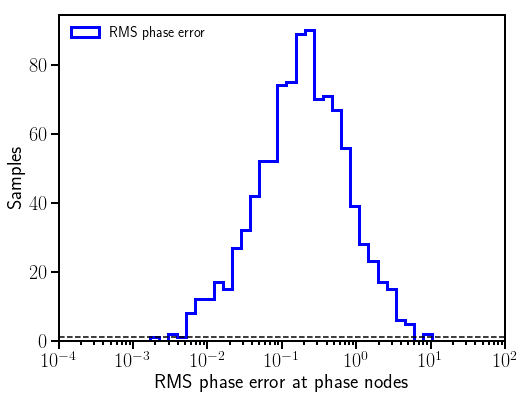

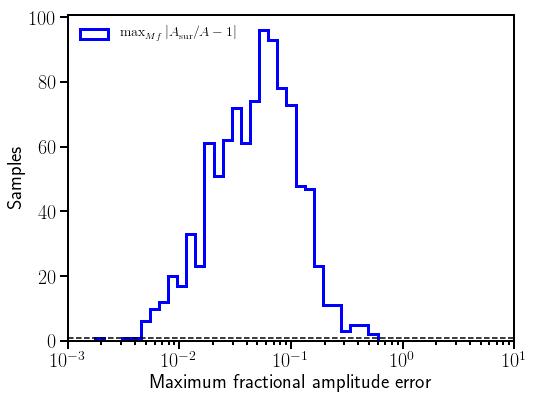

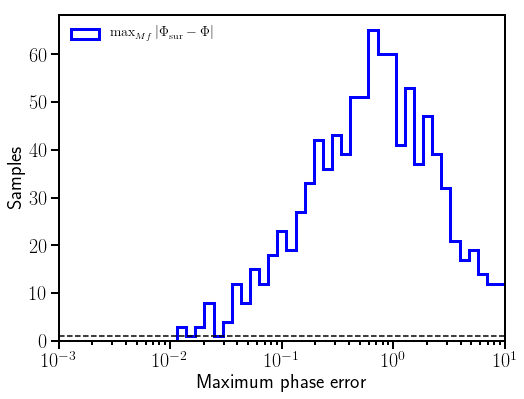

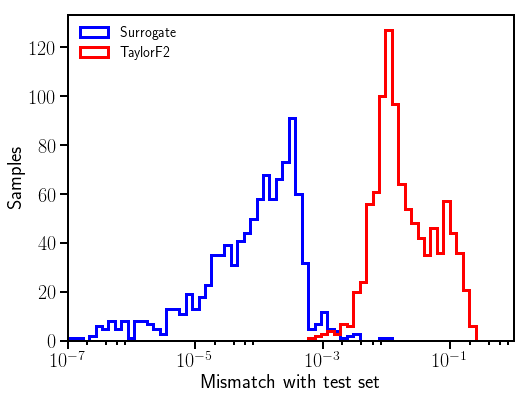

In [32]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 5], bins=np.logspace(-4, 2, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'RMS phase error')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-4, 100.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('RMS phase error at phase nodes')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)




fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.hist(params_errors[:, 6], bins=np.logspace(-3, 1, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 10.0])
#ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)



fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.hist(params_errors[:, 7], bins=np.logspace(-3, 1, 50), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
#ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 10.0])
#ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)



fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(params_errors[:, 8], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='-', lw=3, color='blue', alpha=1.0, label=r'Surrogate')
ax.hist(params_errors[:, 9], bins=np.logspace(-10, 0, 100), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'TaylorF2')

#ax.axhline(1.0, c='k', ls='--')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([1.0e-7, 1.])
#ax.set_ylim([0.9, 1000])
ax.set_xlabel('Mismatch with test set')
ax.set_ylabel('Samples')
ax.legend(loc='upper left', frameon=False)

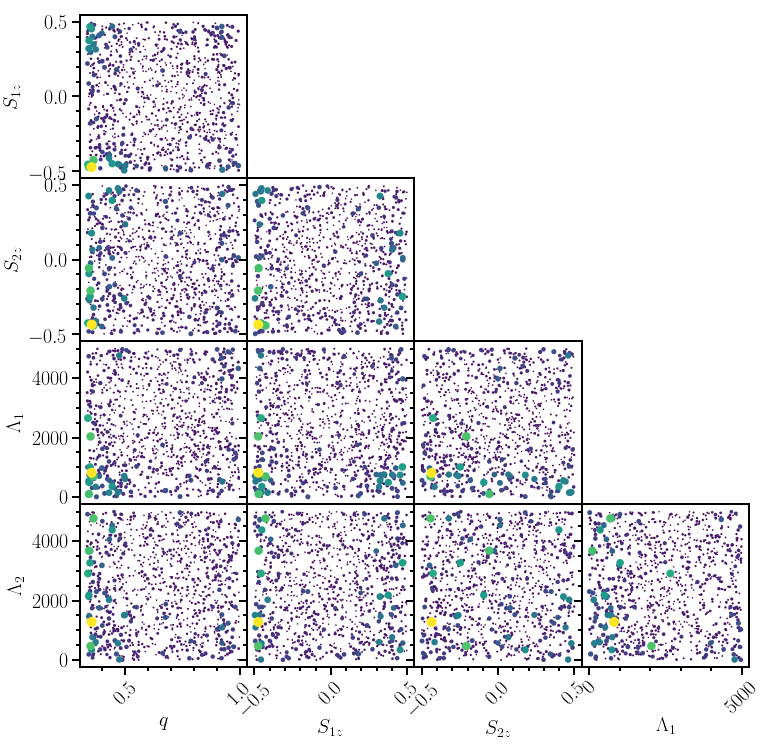

In [16]:
# RMS phase error
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_errors[:, :5]
error = params_errors[:, 5]
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=None, figsize=(10, 10))

# Largest mismatch waveform

990 [  3.528073e-01  -4.749190e-01  -4.368026e-01   8.136580e+02   1.279872e+03] 0.0643034374847


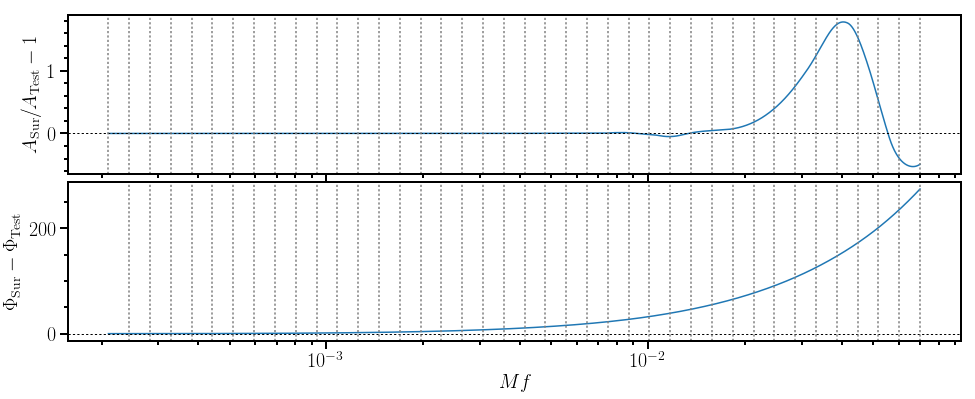

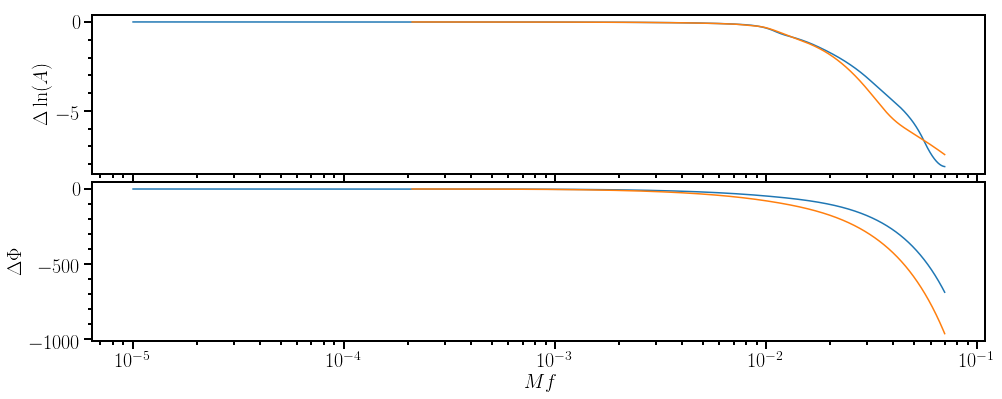

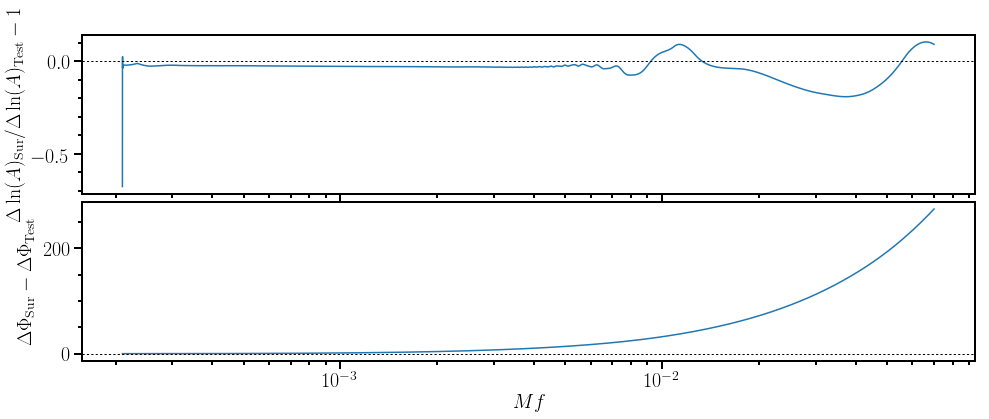

In [17]:
j_err = 8
i_max = np.argmax(params_errors[:, j_err])
#i_max = 0
p = params_errors[i_max, :5]
print i_max, p, params_errors[i_max, j_err]

htest = testset_rand[i_max]
hsur = sur.geometric_waveform(p)
# Resample and zero starting phase
hsur.resample(htest.x)
hsur.phase -= hsur.phase[0]

dhtest = dtestset_rand[i_max]
dhsur = sur.amp_phase_difference(p)


fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
for mf in sur.mf_amp:
    ax1.axvline(mf, c='gray', ls=':')
for mf in sur.mf_phase:
    ax2.axvline(mf, c='gray', ls=':')
#ax1.set_ylim(-0.1, 0.1)
#ax2.set_ylim(-2, 2)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$A_{\rm Sur}/A_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm Sur}-\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')


fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dhsur, dhtest)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

# Compare errors to tidal phase contribution

6 7 3 2 9 5 8 1 4 0

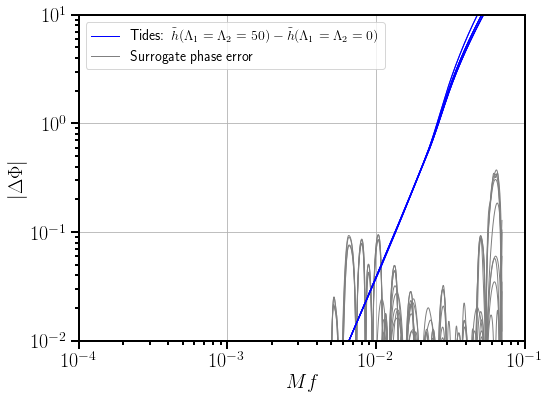

In [21]:
phase_error_indices_sorted_decrease = np.flip(np.argsort(params_errors[:, 7]), 0)

lam = 50.

fig, ax = plt.subplots(figsize=(8, 6))

j = 0
for i in phase_error_indices_sorted_decrease[:10]:
    print i, 
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = sur.geometric_waveform(params)
    # Resample and zero starting phase
    hsur.resample(hrand.x)
    hsur.phase -= hsur.phase[0]

    mfs = hsur.x
    error = np.abs(hsur.phase-hrand.phase)

    params_lam0 = np.array([params[0], params[1], params[2], 0., 0.])
    hsur_lam0 = sur.geometric_waveform(params_lam0)
    
    params_lam = np.array([params[0], params[1], params[2], lam, lam])
    hsur_lam = sur.geometric_waveform(params_lam)
    
    tidal_effect = np.abs(hsur_lam.phase-hsur_lam0.phase)
    
    if j==0:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1, 
                label=r'Tides: $\tilde h(\Lambda_1=\Lambda_2=50)-\tilde h(\Lambda_1=\Lambda_2=0)$')
    else:
        ax.plot(mfs, tidal_effect, ls='-', c='b', lw=1)
        
    if j==0:
        ax.plot(mfs, error, c='gray', lw=1, label='Surrogate phase error')
    else:
        ax.plot(mfs, error, c='gray', lw=1)
    
    j = 1

ax.set_ylabel(r'$|\Delta\Phi|$')
ax.set_xlabel(r'$Mf$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.0001, 0.1)
ax.set_ylim(1.0e-2, 10.)
ax.minorticks_on()
ax.grid()
ax.legend(loc='upper left')

58 [  3.346784e-01   4.232207e-01   1.820563e-01   3.234331e+03   1.462009e+03   1.449279e+00   1.369674e-01
   6.444148e+00   1.447321e-03   5.280345e-03]


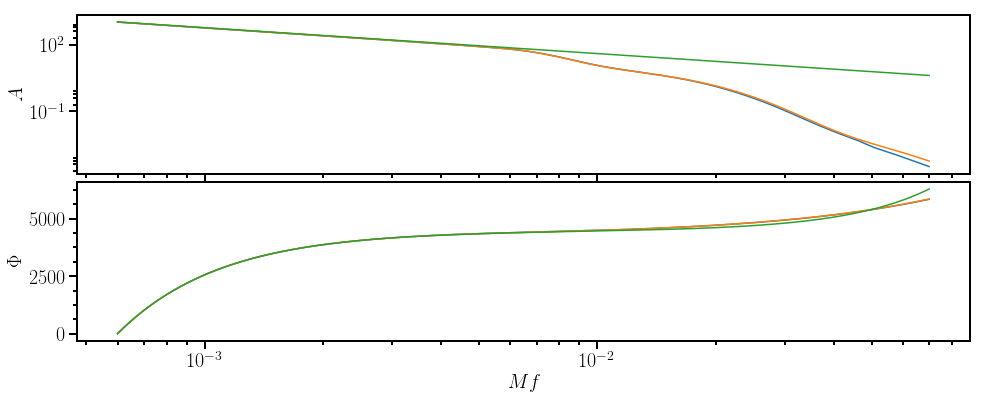

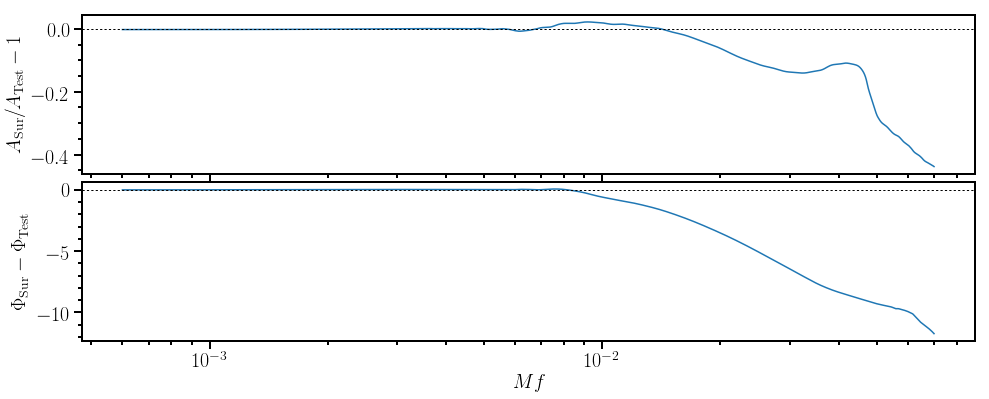

In [69]:
j = 0
max_error_i = phase_error_indices_sorted_decrease[j]
p = params_errors[max_error_i, :5]
hsur = sur.geometric_waveform(p)
htest = testset_rand[max_error_i]
hf2 = sur.geometric_reference_waveform(p)

print max_error_i, params_errors[max_error_i]
fig, (ax1, ax2) = wave.plot_waveforms_fd([hsur, htest, hf2])
ax1.set_yscale('log')
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$A$')
ax2.set_ylabel(r'$\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(hsur, htest)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$A_{\rm Sur}/A_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Phi_{\rm Sur}-\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

58 [  3.346784e-01   4.232207e-01   1.820563e-01   3.234331e+03   1.462009e+03   1.449279e+00   1.369674e-01
   6.444148e+00   1.447321e-03   5.280345e-03]


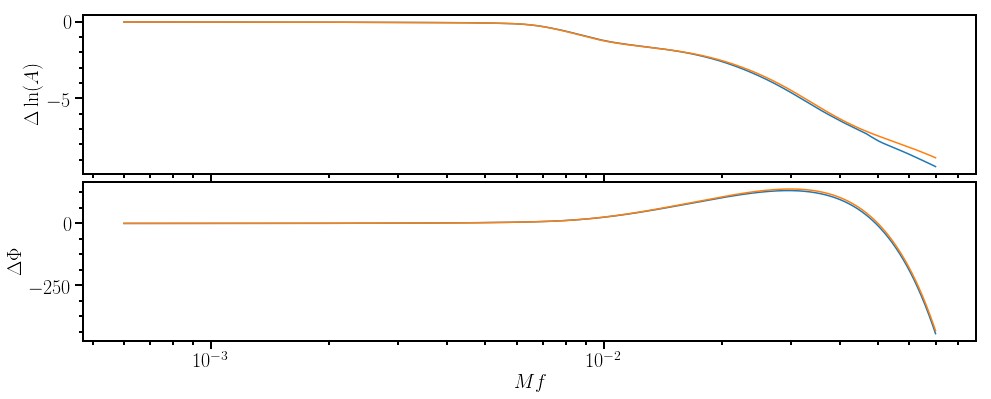

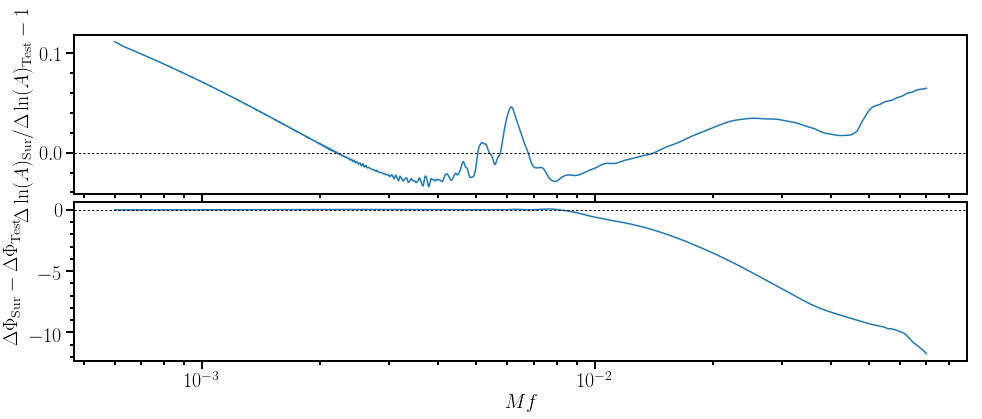

In [70]:
j = 0
max_error_i = phase_error_indices_sorted_decrease[j]
p = params_errors[max_error_i, :5]
dhsur = sur.amp_phase_difference(p)
dhtest = dtestset_rand[max_error_i]
print max_error_i, params_errors[max_error_i]

fig, (ax1, ax2) = wave.plot_waveforms_fd([dhsur, dhtest])
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)$')
ax2.set_ylabel(r'$\Delta\Phi$')
ax2.set_xlabel(r'$Mf$')

fig, (ax1, ax2) = wave.plot_waveform_difference_fd(dhsur, dhtest)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.set_ylabel(r'$\Delta\ln(A)_{\rm Sur}/\Delta\ln(A)_{\rm Test} - 1$')
ax2.set_ylabel(r'$\Delta\Phi_{\rm Sur}-\Delta\Phi_{\rm Test}$')
ax2.set_xlabel(r'$Mf$')

In [41]:
rms_phase_error_i = np.flip(np.argsort(params_errors[:, 5]), 0)[:100]
max_phase_error_i = np.flip(np.argsort(params_errors[:, 7]), 0)[:100]
print rms_phase_error_i
print max_phase_error_i
# set is like list, but not. Learn about it.
common_i = list(set(rms_phase_error_i).intersection(max_phase_error_i))
print len(common_i)

[465 310  75 427 978 768 111 658 696 522 700 807 469 814 759 504 343 570 677 684 646 468  24 370 843 551  33
 792 326 654   6 621 893 182 181 824  60 857 659 226 777 859 162 703 708 827 885 689 275 625 197 600 338 933
 780  90 760 681  82 610 364 463 631  79 450 373 470 839 398 220 288 937 563 868 726  14 225 496 894 767 966
 534 173 156 377 945 854 423  55 553 532 686 280 796 475 184 738 505 400 905]
[465 310  75 427 768 978 700 111 814 522 759 343 469 658 646 807 504 696 326 677 468 370 684  24 570 659 857
 708 933 551 689  33 162  60 893 681 621 275 182 859 654 226 470 843 600 197 364 885 777  82 792   6 827 463
 824 760 703 338 398 181 780 610 373 937 377  79 625  90 796 726 220 423 288 945 894 496 532 631 225 277 839
 475 738 868 173 358 553 505  55 852 113 104 905 156 450 767 295 280 400 254]
93


# Create 3rd training set from largest phase error waveforms

In [27]:
params = params_errors[:, :5]
errors = params_errors[:, 5]
i_above_thresh = np.where(errors>=0.1)[0]
print i_above_thresh
new_params = params[i_above_thresh]
new_errors = errors[i_above_thresh]

print len(new_errors)
new_errors

[  2   3   4   8   9  10  11  12  13  16  18  19  24  25  26  27  28  30  31  32  34  35  37  38  40  41  42
  43  45  46  48  49  54  56  58  59  60  61  63  64  65  66  68  70  72  74  75  76  77  78  79  80  82  83
  84  86  87  88  89  91  93  94  95  96  97  98  99 100 102 105 106 109 112 113 115 116 117 118 119 120 122
 123 124 125 126 127 128 130 131 132 136 137 138 139 141 142 143 144 146 150 151 153 155 156 157 160 161 162
 164 165 166 167 170 174 175 177 178 179 180 184 185 187 190 191 193 195 196 198 201 203 204 205 207 209 210
 211 213 214 215 218 219 220 222 223 224 226 227 228 229 232 233 234 235 237 238 241 242 243 244 245 246 247
 248 250 253 254 257 259 260 261 264 265 266 267 268 269 270 272 273 276 277 279 281 283 284 285 288 291 293
 297 298 299 300 301 302 303 305 306 307 308 309 311 313 314 315 317 318 319 321 325 327 328 330 332 333 334
 335 336 337 338 340 341 343 344 345 348 349 351 353 354 355 356 360 363 365 366 368 372 373 375 376 378 379
 380 381 383 384 38

array([ 0.141352,  0.124667,  0.325105,  0.462087,  0.224952,  0.219505,  0.248367,  0.502072,  0.264783,
        0.479045,  0.270056,  0.135417,  0.137398,  0.186444,  0.145657,  0.270563,  0.231249,  0.306189,
        0.363363,  0.392404,  0.311683,  0.470556,  0.180486,  0.314438,  0.484149,  0.620924,  0.112532,
        0.157616,  0.140426,  0.331137,  0.307859,  0.221431,  0.21001 ,  0.133522,  0.178143,  0.129844,
        0.571435,  0.177998,  0.151044,  0.341131,  1.963744,  0.590722,  0.1017  ,  0.479725,  0.24351 ,
        0.318129,  0.109639,  0.259688,  0.219735,  0.626525,  0.68818 ,  0.390636,  0.275374,  1.593032,
        0.144504,  0.264758,  0.132053,  0.271573,  0.28684 ,  0.72654 ,  0.595566,  0.183512,  0.101068,
        0.455386,  0.385631,  0.208378,  0.446789,  0.151203,  0.954138,  0.422649,  0.170371,  0.175621,
        0.279164,  0.144607,  0.168904,  0.223518,  0.182992,  0.561596,  0.496644,  0.203707,  0.365909,
        0.106384,  0.212031,  0.196571,  0.197

In [30]:
# new_h_list = [testset_rand[i] for i in i_above_thresh]
# new_dh_list = [dtestset_rand[i] for i in i_above_thresh]

# h_filename = '../../data/teobtest40hz/h_train_rand.hdf5'
# dh_filename = '../../data/teobtest40hz/dh_train_rand.hdf5'
# ws.waveform_set_from_list(h_filename, new_h_list, new_params)
# ws.waveform_set_from_list(dh_filename, new_dh_list, new_params)

In [31]:
# filename1 = '../../data/teobtest40hz/h_train_lhd_uncsamp.hdf5'
# filename2 = '../../data/teobtest40hz/h_train_rand.hdf5'
# filename_join = '../../data/teobtest40hz/h_train_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)

# filename1 = '../../data/teobtest40hz/dh_train_lhd_uncsamp.hdf5'
# filename2 = '../../data/teobtest40hz/dh_train_rand.hdf5'
# filename_join = '../../data/teobtest40hz/dh_train_lhd_uncsamp_rand.hdf5'
# ws.join_waveform_sets(filename1, filename2, filename_join)